<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Introduction to keras<br><br>
<br><br>Week 14 of INFS 772 Spring 2019<br></p>
<p style="font-family: Arial; font-size:1.5em;color:#2462C0; font-style:bold"><br>Keras is a high-level neural networks API, written in Python and capable of running on top of either [TensorFlow](https://www.tensorflow.org) or [Theano](http://deeplearning.net/software/theano/). </p>

> It was developed with a focus on enabling fast experimentation. 
> Being able to go from idea to result with the least possible delay is key to doing good research.

If you've used [scikit-learn](http://scikit-learn.org/stable/) then you should be on familiar ground as the library was developed with a similar philosophy.

 * Can use either theano or tensorflow as a back-end. For the most part, you just need to set it up and then interact with it using keras. Ordering of dimensions can be different though.
 * Models can be instaniated using the `Sequential()` class. 
 * Neural networks are built up from bottom layer to top using the `add()` method.

### Skip this part since we have already conda installed the packages.

Before starting we'll need to make sure tensorflow and keras are installed. Open a terminal and type the following commands:
```sh
pip install tensorflow
pip install keras 
```

The back-end of keras can either use theano or tensorflow. Verify that keras will use tensorflow by using the following command:

```sh
type ..\.keras\keras.json
```

In [24]:
!type ..\.keras\keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}




The keras library is very flexible, constantly being updated and being further integrated with tensorflow. Some example scripts for keras can be found 

Another advantage is its intergration with [tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard): A visualisation tool for neural network learning and debugging. To start we need to install it. If you've installed tensorflow already then you should already have it (check with: `where tensorboard`). Otherwise, run the command:
```sh
pip install tensorflow
```

### Training a neural network revolves around the following objects:
- Layers, which are combined into a network (or model)
- The input data and corresponding targets
- The loss function, which defines the feedback signal used for learning
- The optimizer, which determines how learning proceeds
#### The network, composed of layers that are chained together, maps the input data to predictions. The loss function then compares these predictions to the targets, producing a loss value: a measure of how well the network’s predictions match what was expected. The optimizer uses this loss value to update the network’s weights.

### Building deep-learning models in Keras is done by clipping together compatible layers to form useful data-transformation pipelines.
We begin by importing the keras library as well as the `Sequential` model class which forms the basic skeleton 
for our neural network. We'll only consider one type of layer, where all the neurons in a layer are connected to all
the other neurons in the previous layer

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [50]:
!where tensorboard

C:\Users\dzeng\AppData\Local\Programs\Python\Python36\Scripts\tensorboard.exe


## Create the data

We start by creating some fake data. We'll use the scikit-learn library in order to do this.

In [51]:
%pylab inline
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
X, Y = make_moons(noise=0.2, random_state=0, n_samples=2000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

Populating the interactive namespace from numpy and matplotlib


c:\users\dzeng\appdata\local\programs\python\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['contour', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


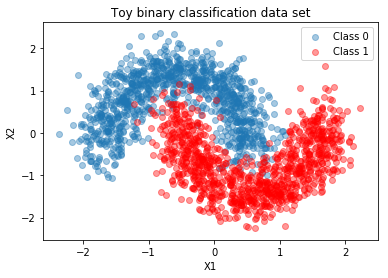

In [52]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0', alpha=0.4)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1', alpha=0.4)
ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

Our data has a binary class (0 or 1), with two input dimensions ($X1$ and $X2$) and is visualised above. In order 
to correctly classify the class the neural network will need to successfully separate out the zig-zag shape that intersects
where the two classes meet.

## Creating a neural network
We'll create a very simple multi-layer perceptron with one hidden layer.

This is done in keras by first defining a `Sequential` class object. Layers are then added from the initial layer
that includes the data, so we need to specifiy the number of input dimensions using the keyword `input_dim`. We also define the acitvation of this layer to be a rectified linear unit `relu`. 

Finally a densely connected layer is added with one output and a `sigmoid` activation corresponding to the binary class.

In order to fit this model we need to `compile` it by giving it the optimizer, loss and any additional metrics we want to consider. 

In [54]:
#Create sequential  multi-layer perceptron
#uncomment if you want to add more layers (in the interest of time we use a shallower model)
model = Sequential()

#X1,X2 input dimensions. connecting to 32 neurons with relu activation
model.add(Dense(32, input_dim=2,activation='relu')) 

#binary classification so one output
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='AdaDelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


## Adding in a callback for tensorboard
Next we define a callback for the model. This basically tells keras what format and where to write the data such that tensorboard can read it. Using the sub-folder structure as below allows us to compare between multiple models or multiple training of the same model.

In [56]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/tmp/model2', 
                                          histogram_freq=0, write_graph=True, 
                                          write_images=False)

Now perform model fitting. Note where we've added in the callback.

In [58]:
model.fit(X_train, Y_train, batch_size=32, epochs=200,
          verbose=0, validation_data=(X_test, Y_test),callbacks=[tb_callback])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09373451533913613
Test accuracy: 0.967


## Plotting the model prediction across the grid
We can create a grid of $(x,y)$ values and then predict the class probability on each of these values using our fitted model. We'll then plot the original data with the underlying probabilities to see what the classification looks like and how it compares to the data

In [59]:
grid = np.mgrid[-3:3:100j,-3:3:100j] #returns a dense multi-dimensional “meshgrid”
grid_2d = grid.reshape(2, -1).T
X, Y = grid
prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)

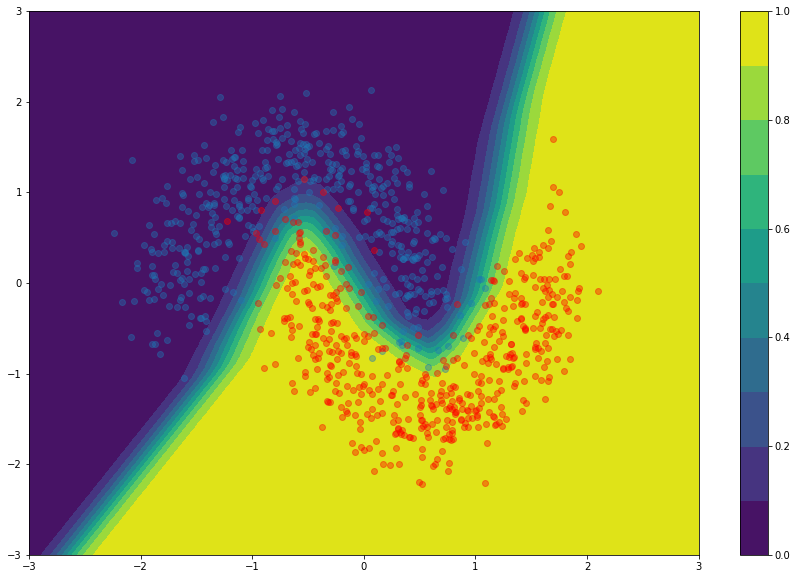

In [60]:
##plot results
fig, ax = plt.subplots(figsize=(15, 10))
contour = ax.contourf(X, Y, prediction_probs.reshape(100, 100), 10) # draw filled contours
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], alpha=0.4)
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r', alpha=0.4)
cbar = plt.colorbar(contour, ax=ax)

As you can see in the graph above, the model able to fully capture the zig-zag pattern to fully separate the classes. We could potentially experiment adding more layers or additional input ($xy$ for instance).

## Visualising results
Now we visualise the results by running the following in the same terminal as this script
```sh
tensorboard --logdir=/tmp/model1
```

This runs a local server where we can view the results in browser. The plot below gives an example of what can be visualised. Here we ran the same model for the same number of epochs (remember to specifiy a new subfolder for each instance in order to compare the results). Tensorboard has many more features including visualisation of the neural network. You can check out the documentation [here](https://www.tensorflow.org/get_started/summaries_and_tensorboard)
![image](tensorboard_example.png)

## Conclusion

- Keras is a high-level Python library for Deep Learning models
- A model is a network of layers
- A typical Keras workflow:
    1. Define your training data: input tensors and target tensors.
    2. Define the model architecture that maps inputs to targets.
        Instaniate the model with Sequential() class; build it up from bottom layer to top with add() method.
    3. Configure the learning process by specifying a loss function, an optimizer, and some performance metrics with compile() method.
    4. Iterate on your training data with fit() method.
- TensorBoard is a TensorFlow tool for visualizing learning.
    - You use TensorBoard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data like images that pass through it. 